In [1]:
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [26]:
nbf64 = 32

/tf/tensorflow-tutorials/myfiles/archive/chest_xray/train


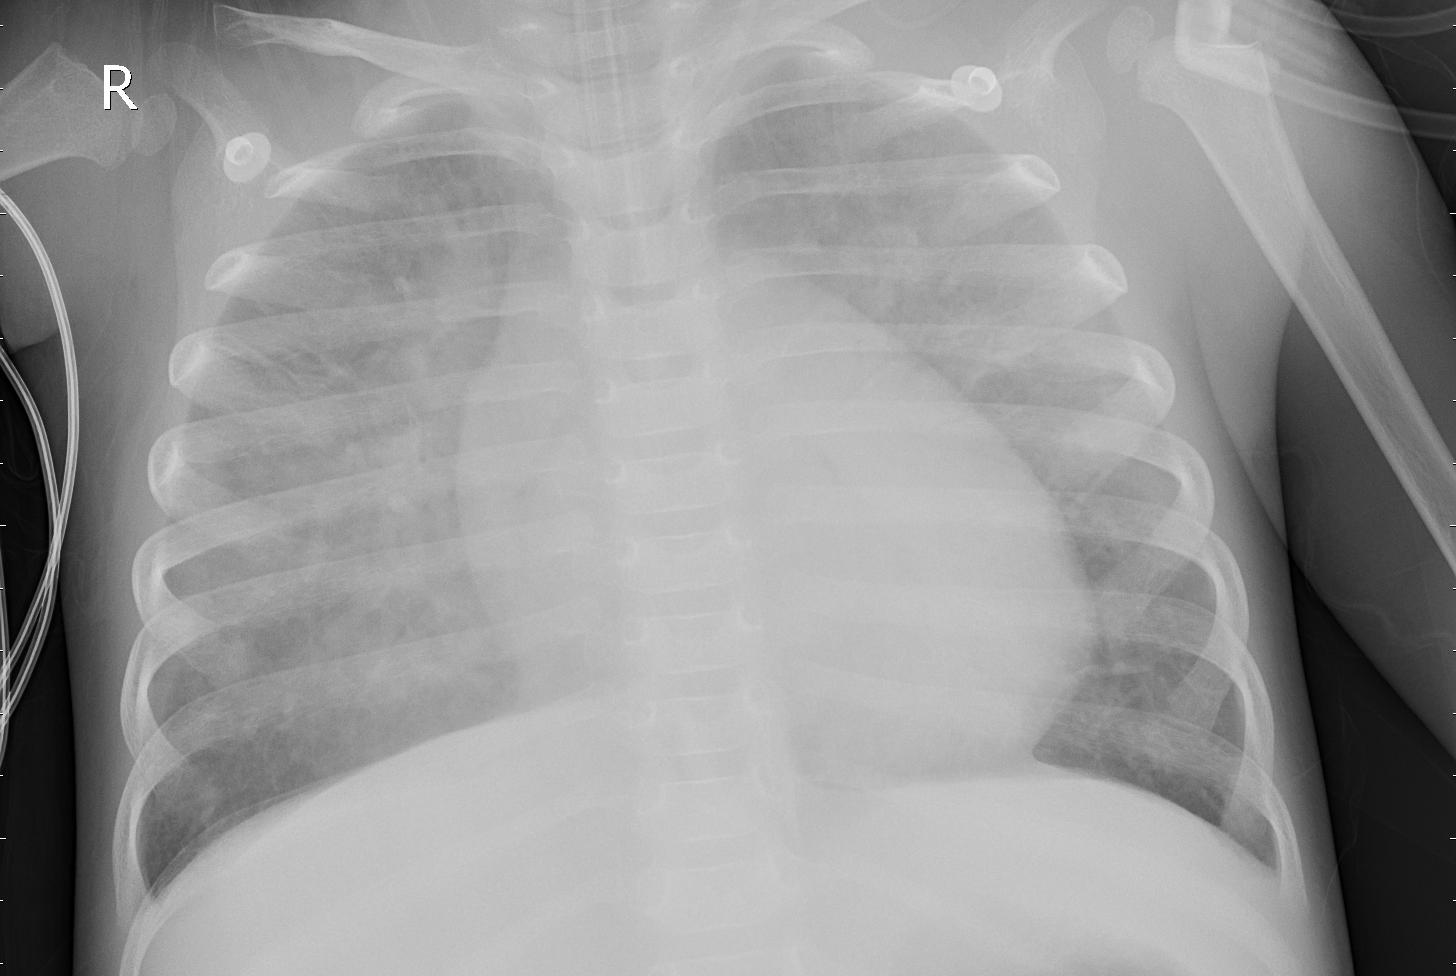

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import sklearn.preprocessing
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

data_dir = pathlib.Path('/tf/tensorflow-tutorials/myfiles/archive/chest_xray/train')
print(data_dir)
pneumonia = list(data_dir.glob('PNEUMONIA/*'))
PIL.Image.open(str(pneumonia[0]))


In [6]:
batch_size = 32
img_height = 256
img_width = 256

In [86]:
data_dir = pathlib.Path('/tf/tensorflow-tutorials/myfiles/archive/chest_xray/new_train')
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1000 files belonging to 2 classes.
Using 800 files for training.


In [87]:
data_dir = pathlib.Path('/tf/tensorflow-tutorials/myfiles/archive/chest_xray/new_val')
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [88]:
class_names = train_ds.class_names
print(class_names)


['NORMAL', 'PNEUMONIA']


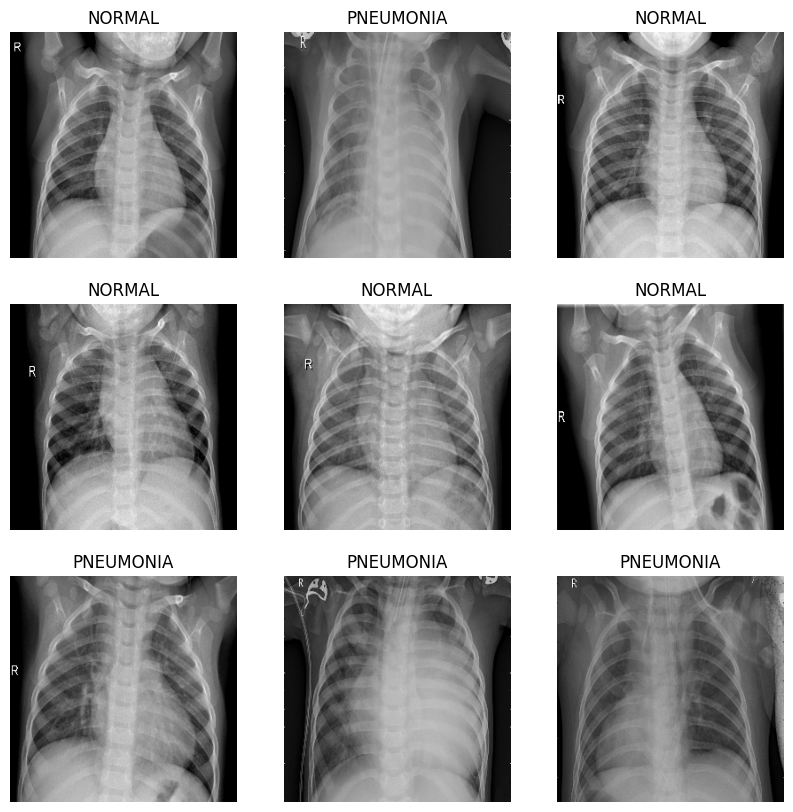

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [109]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import scipy

input_size = (256,256,3)

model = tf.keras.Sequential()
model.add(Conv2D(nbf64, 3, activation='relu',input_shape=input_size))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(nbf64, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(nbf64*2, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(nbf64*2, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2))



In [110]:
import keras

model.compile(keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [111]:
model.fit(train_ds, 
        epochs=50, 
        validation_data=val_ds)


Epoch 1/50
25/25 [==============================] - 2s 55ms/step - loss: 2.4715 - accuracy: 0.5825 - val_loss: 1.1496 - val_accuracy: 0.6550
Epoch 2/50
25/25 [==============================] - 1s 49ms/step - loss: 0.9027 - accuracy: 0.7287 - val_loss: 0.7637 - val_accuracy: 0.7400
Epoch 3/50
25/25 [==============================] - 1s 49ms/step - loss: 0.6522 - accuracy: 0.7812 - val_loss: 0.7654 - val_accuracy: 0.7700
Epoch 4/50
25/25 [==============================] - 2s 50ms/step - loss: 0.5274 - accuracy: 0.8325 - val_loss: 0.5125 - val_accuracy: 0.8250
Epoch 5/50
25/25 [==============================] - 1s 49ms/step - loss: 0.4118 - accuracy: 0.8625 - val_loss: 0.6495 - val_accuracy: 0.8100
Epoch 6/50
25/25 [==============================] - 2s 49ms/step - loss: 0.3386 - accuracy: 0.8813 - val_loss: 0.4767 - val_accuracy: 0.8450
Epoch 7/50
25/25 [==============================] - 1s 49ms/step - loss: 0.2999 - accuracy: 0.8963 - val_loss: 0.3877 - val_accuracy: 0.8700
Epoch 8/50
25

In [112]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 30, 30, 64)     

In [114]:
data_dir = pathlib.Path('/tf/tensorflow-tutorials/myfiles/archive/chest_xray/test/PNEUMONIA/')
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        img = tf.keras.utils.load_img(
            os.path.join(data_dir,dirname,filename), target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )


1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to NORMAL with a 99.96 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONI

1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.97 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 99.98 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.96 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMON

1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.96 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 98.99 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMO

1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.87 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.97 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.93 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.98 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONI

1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 99.95 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 98.87 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.71 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.99 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONI

1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 94.20 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 97.29 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 99.91 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMON

1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 99.99 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMONIA with a 99.97 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 100.00 percent confidence.
1/1 [==============================] - 0s 11ms/step
This image most likely belongs to PNEUMONIA with a 99.99 percent confidence.
1/1 [==============================] - 0s 12ms/step
This image most likely belongs to PNEUMON

In [63]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [56]:
train_images = train_images / 255.0

test_images = test_images / 255.0


In [64]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [76]:
input_size = (28,28,1)

model = tf.keras.Sequential()
model.add(Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',input_shape=input_size))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(nbf64, 3, activation='relu',padding = 'same', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [77]:
model.fit(train_images, train_labels, epochs=10)


Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1983 - accuracy: 0.6716
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6126 - accuracy: 0.7761
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5182 - accuracy: 0.8210
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4417 - accuracy: 0.8470
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3817 - accuracy: 0.8664
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3462 - accuracy: 0.8765
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3201 - accuracy: 0.8874
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2950 - accuracy: 0.8965
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2787 - accuracy: 0.9032
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.257

In [78]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3299 - accuracy: 0.8902 - 344ms/epoch - 1ms/step

Test accuracy: 0.8902000188827515
